# Linear and Logistic Regression

Some problems can't be solved analitically or through imperative programming. For those problems, where the Maximum Likelihood Estimators can't be found trivially, we usually solve them in the form of an optimization problem.

Not long ago I woke up realizing that I had some gaps in my knowledge of Logistic Regression. It's time that I closed that gap, and maybe helped some people along the way.

## An Intro and Linear Regression

Given explanatory variables $X \in \mathbb{R}^n$ where $n$ is the amount of variables, we define parameters $\theta \in \mathbb{R}^m$ where $m \ge n$. It's greater than or equals because we could be including something we know as the *bias* term. These parameters are learned from samples that include these explanatory variables and the linear combination of these parameters results in an estimation of a target variable $y \in \mathbb{R}$, such that our estimation $\hat{y} = \theta X + \epsilon$ where $\epsilon$ is an unseen random variable that represents noise, such as measurement errors, this is usually also known as the [bayesian error](https://en.wikipedia.org/wiki/Bayes_error_rate). Do note that $\epsilon \in \mathbb{R}^m$ as well.

Layman's terms now: suppose we've got data about housing prices in some place in the world, and the only thing we know about these houses are their *size* in square meters, and their *price*. In this case, the explanatory variables ($X$) are just the *size*, and the target variable ($y$) is the *price*. The $\epsilon$ value would be any measurement errors when we calculate the *size*. Suppose that we have a new house, and we don't know its price, but we *do* know its size in square meters. If we had a model, or a function that explained the tendency of the prices as a **function of the size**, then we'd be able to **estimate the price**.

This represents a single-variable function $f(x) = y$, which is actually the *true price*, which we don't know! We don't actually know this function, but we'll try to get close to it, so, using that same notation, what we're trying to find is the closest function to $f(x)$, $g(x)$, which predicts an output we know as $\hat{y}$, because it's an estimate. Let's make this a bit more tangible by putting it into code.

In [1]:
# Import some useful stuff
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
# Helper function to set up a common layout in plotting
def set_plot_layout():
    ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_alpha(0.35)
    ax.spines["bottom"].set_alpha(0.35)
    ax.tick_params(axis=['x', 'y'], alpha=0.35)
    plt.grid(c="white", alpha=0.6)
    ax.set_facecolor("#f3f3f3")

In [3]:
X = np.arange(100, 500)

So, we've just randomly sampled a couple of house sizes, and we'll define the function $f(x)$ (the true function, the one we don't have in practice!) as $f(x) = 12.5 \cdot x = y$. We're ignoring $\epsilon$ as we assume it is already contained within $X$.

In [4]:
# Define our true function f(x) and get our values for our sample data.
f_x = lambda x: 12.5 * x
y = f_x(X)

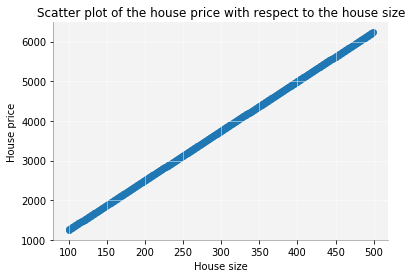

In [5]:
plt.scatter(X, y)
plt.xlabel("House size")
plt.ylabel("House price")
plt.title("Scatter plot of the house price with respect to the house size")
set_plot_layout()

Of course, if we were to plot our defined function $f(x) = 12.5\cdot x$, we'd get a perfect fit:

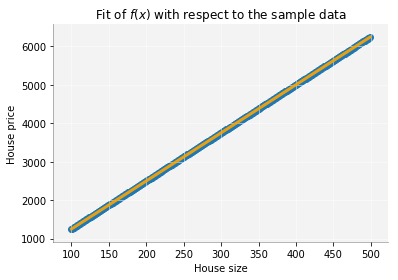

In [6]:
plt.plot(X, f_x(X), c="orange", alpha=0.9, linewidth=3)
plt.scatter(X, y)
plt.xlabel("House size")
plt.ylabel("House price")
plt.title("Fit of $f(x)$ with respect to the sample data")
set_plot_layout()

But in the real world we don't actually know $f(x) = y$, so we need to find a new function, $g(x) = \hat{y}$ that gets as close as possible to $f(x)$. If we were to generalize this into a multiple-explanatory-variable problem, we would say that we're looking for a $\hat{y} = \theta X$ that is closest to $y$. This is what we're trying to find with *linear regression*, and in order to achieve this, we'll use a very, very known algorithm in machine learning known as *batch gradient descent*.

### Batch Gradient Descent

We don't actually know the function that generated $y$, so we want to find the parameters that approximate an estimation $\hat{y}$ to the target variable $y$ that is explained by the explanatory variables $X$, in order to do this, we need a way to do two three things:

1. Formulate a hypothesis of the linear combination of the explanatory variables, these hypotheses are formally said to come from a given hypothesis space defined by our solution to the problem. For example, if we only check linear solutions, that's our hypothesis space. The hypothesis uses the known explanatory variables to estimate $y$ as $\hat{y}$
2. Check whether this hypothesis' output is close enough to $y$, for this we use a **loss function** that is minimized iteratively.
3. In order to formulate a better hypothesis, we must change our estimated parameters $\theta$, which is achieved by going in the opposite direction of the **gradient** of the **loss function**, where the gradient is a vector composed of all partial derivatives of all parameters to be learned and points in the direction of steepest ascent, but we want to minimize error! Not maximize it, so we go on the opposite direction.

There are many loss functions to choose from, in this case we'll use one known as **mean squared error**, which looks like this:

$$
J(\theta) = MSE = \frac{1}{2m} \sum_{i=1}^{m}(\hat{y}^{(i)} - y^{(i)})^2
$$

Note that $m$ is the sample size, and the $(i)$ superscript does not refer to a power, but rather to the a sample. Note that since $\theta$ is a vector, what we're actually doing is calculating the derivative for each coefficient $\theta$.

$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^{m}(\theta_i x^{(i)} - y^{(i)})^2
$$

For $\theta_0$, $x$ is actually a constant, so the derivative looks something like this:

$$
\frac{dJ(\theta)}{d\theta_0} = \frac{1}{2m}\sum_{i=1}^{m}2(\theta_i x^{(i)} - y^{(i)}) = \frac{1}{m} \sum_{i=1}^{m}(\theta_i x^{(i)} - y^{(i)})
$$

and for $\theta_{1 .. n}$, the derivative looks like this:

$$
\frac{dJ(\theta)}{d\theta_{i \gt 0}} = \frac{1}{2m}\sum_{i=1}^{m}2x^{(i)}(\theta_i x^{(i)} - y^{(i)}) = \frac{1}{m} \sum_{i=1}^{m}(\theta_i x^{(i)} - y^{(i)})x^{(i)}
$$

And we update our coefficients $\theta$ by using these derivatives accompanied with a *learning rate* $\alpha$, which is something known as a *hyper-parameter* which defines how big our "steps" in the opposite direction of the gradient will be, in this way:

$$
\begin{align*}
    \theta_0 & = \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(\theta_i x^{(i)} - y^{(i)}) \\
    \theta_{i > 0} & = \theta_{i > 0}  - \alpha \frac{1}{m}\sum_{i=1}^{m}(\theta_i x^{(i)} - y^{(i)})x^{(i)}
\end{align*}
$$

This process is repeated for as many iterations as we wish or until convergence, which is the point where the steps become too small. And we can now code this!

There's also something nice about this: we're purposefully adding an explanatory variable $x_0$ that is made only of $1$s, which allows us to include the bias into the derivative for all $\theta$ values, and so we only have to calculate this derivative:

$$
\theta = \theta  - \alpha \frac{1}{m}\sum_{i=1}^{m}(\theta_i x^{(i)} - y^{(i)})x^{(i)}
$$

which we can define in vectorized form: let $E = \hat{y} - y$, we define $\frac{dJ(\theta)}{d\theta}$ as:

$$
\frac{dJ(\theta)}{d\theta} = \frac{1}{m} X \cdot E
$$

and the update step ends up looking as:

$$
\theta = \theta - \alpha \frac{1}{m} X \cdot E
$$

In [7]:
class LinearRegression:
    
    def __init__(self, alpha=1e-5, tol=0.0001, iterations=20):
        self.alpha = alpha
        self.tol = tol
        self.iters = iterations
        
    def predict(self, x):
        if np.any(np.isnan(self.theta)):
            raise ValueError("fit function not yet called.")
        x = np.vstack([np.ones(len(x)), x])
        return np.dot(self.theta.T, x)
    
    def fit(self, x, y):
        assert len(x) == len(y)
        self.theta = np.zeros(x.ndim + 1) # Because we have a bias term!
        history = []
        for i in range(1, self.iters + 1):
            prev_mse = self.calculate_mse(x, y)
            theta_change = self.calculate_gradient(x, y)
            history.append({"iteration": i, 
                            "theta": self.theta.copy(), 
                            "mse": prev_mse})
            self.theta -= theta_change
            mse = self.calculate_mse(x, y)
            if abs(prev_mse - mse) < self.tol:
                print("Converged at iteration {}.".format(i))
                break
        return history
        
    def calculate_gradient(self, x, y):
        m = len(x)
        pred = self.predict(x)
        err = pred - y
        x = np.vstack([np.ones(len(x)), x])
        theta_change = self.alpha * (1/m) * np.dot(x, err)
        return theta_change
    
    def calculate_mse(self, x, y):
        preds = self.predict(x)
        m = len(x)
        mse = (1 / (2 * m)) * np.sum(preds - y) ** 2
        return mse

Converged at iteration 13.


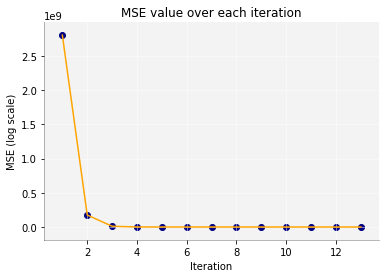

In [8]:
regressor = LinearRegression(alpha=0.75)
# Features caling happening right here
scaled_X = (X - np.mean(X)) / np.std(X)
history = regressor.fit(scaled_X, y)
iteration, mse = zip(*[(hist["iteration"], hist["mse"]) for hist in history])
plt.plot(iteration, mse, c="orange")
plt.scatter(iteration, mse, c="navy")
plt.title("MSE value over each iteration")
plt.xlabel("Iteration")
plt.ylabel("MSE (log scale)")
set_plot_layout()

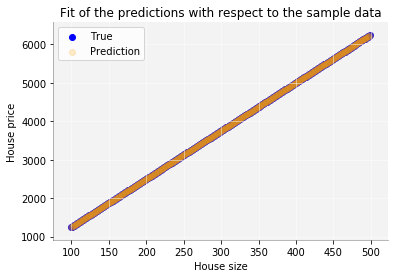

In [9]:
pred = regressor.predict(scaled_X)
plt.scatter(X, y, c="blue", alpha=1, label="True")
plt.scatter(X, pred, c="orange", alpha=0.2, label="Prediction")
plt.xlabel("House size")
plt.ylabel("House price")
plt.legend()
plt.title("Fit of the predictions with respect to the sample data")
set_plot_layout()

Just for sanity, let's make sure this works as well with a decreasing function.

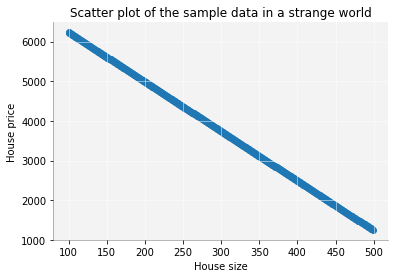

In [10]:
# We reverse the values to create a decreasing function
g_x = lambda x: x[::-1] * 12.5
new_y = g_x(X)
plt.scatter(X, new_y)
plt.xlabel("House size")
plt.ylabel("House price")
plt.title("Scatter plot of the sample data in a strange world")
set_plot_layout()

Converged at iteration 13.


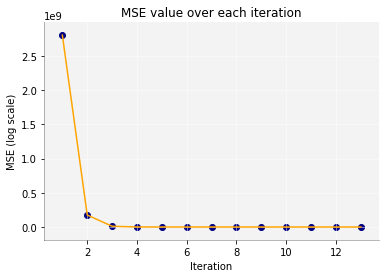

In [11]:
regressor = LinearRegression(alpha=0.75, iterations=100)
history = regressor.fit(scaled_X, new_y)
iteration, mse = zip(*[(hist["iteration"], hist["mse"]) for hist in history])
plt.plot(iteration, mse, c="orange")
plt.scatter(iteration, mse, c="navy")
plt.title("MSE value over each iteration")
plt.xlabel("Iteration")
plt.ylabel("MSE (log scale)")
set_plot_layout()

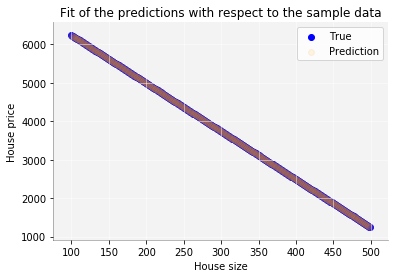

In [12]:
pred = regressor.predict(scaled_X)
plt.scatter(X, new_y, c="blue", alpha=1, label="True")
plt.scatter(X, pred, c="orange", alpha=0.1, label="Prediction")
plt.xlabel("House size")
plt.ylabel("House price")
plt.legend()
plt.title("Fit of the predictions with respect to the sample data")
set_plot_layout()

You may have noticed that I'm doing something to the input variable $X$, and what I'm doing to it is called **mean normalization**, it's an operation that looks like this:

$$
X = \frac{X - \mu{X}}{\sigma(X)}
$$

Which makes the mean of $X$ equal to $0$ and its standard deviation equal to $1$. This is *extremely* useful, because the values are centered, and it makes the gradient steps much simpler and tends to reduce the amount of iterations we have to perform because our learning rate can be higher. Otherwise, the gradient steps are erratic, and if there's multiple explanatory variables, if we did not perform feature scaling (which in this case is the mean normalization method), we would actually require a different learning rate for each explanatory variable, which means that, if we wanted to converge, we'd need to use a very small learning rate. Through feature normalization, we avoid this problem.

## Classification through Linear Regression

Logistic Regression is, in a very simple but naive way of saying, Linear Regression for categorical target variables, where a categorical target variable is discrete. In the case of **binary classification**, which is the case we'll cover here, $y \in [-, +]$, which means that $y$ is either a *positive* or a *negative* case. We could also say that $y \in [0, 1]$, which roughly means that $y$ may either be $0$ or $1$. Although there's some stuff to say about Logistic Regression, we **can** use Linear Regression to try to predict a target variable between 0 and 1, and anything greater than or equal to $0.5$ is considered a positive case, and anything below $0.5$ is considered a negative case. As soon as we do this we'll probably see the short comings of Linear Regression in classification, and why Logistic Regression exists in the first place.

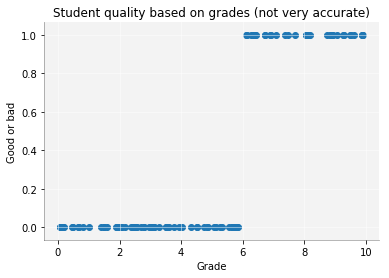

In [13]:
# Let's create a model that says whether a student is "good"
# or "bad" based on their grades.
X = np.random.uniform(high=10, size=100)
y = [1 if x > 6 else 0 for x in X]
plt.scatter(X, y)
plt.xlabel("Grade")
plt.ylabel("Good or bad")
plt.title("Student quality based on grades (not very accurate)")
set_plot_layout()

In [14]:
classifier = LinearRegression(alpha=0.5, iterations=20)
scaled_X = (X - np.mean(X)) / np.std(X)
history = classifier.fit(scaled_X, y)

Converged at iteration 9.


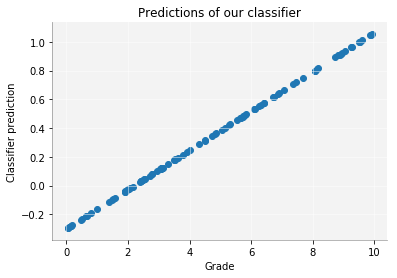

In [15]:
# Let's look at our predictions, using our scaled X.
predictions = classifier.predict(scaled_X)
plt.scatter(X, predictions)
plt.xlabel("Grade")
plt.ylabel("Classifier prediction")
plt.title("Predictions of our classifier")
set_plot_layout()

As you can see, this doesn't look like the result of a classifier, but rather like the result of a regression. We're missing something here, which is the last part we mentioned at the introduction of Logistic Regression, which is to assign $0$ or $1$ based on whether the value is greater than or equals to $0.5$ or not. We'll be checking the ratio of how many of our predictions are equal to the actual target value of the target variable $y$ as well.

Our classifier was 100.0% accurate.


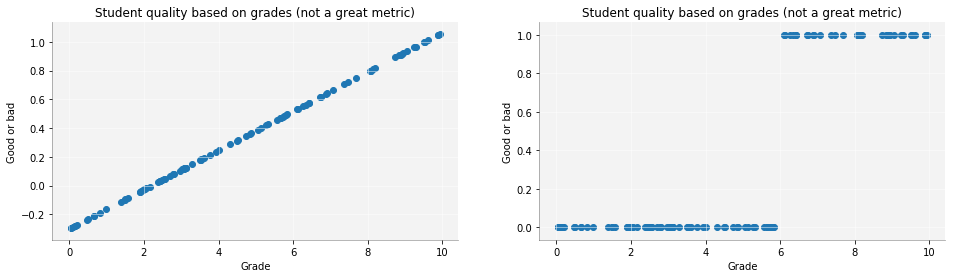

In [16]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.scatter(X, classifier.predict(scaled_X))
plt.xlabel("Grade")
plt.ylabel("Good or bad")
plt.title("Student quality based on grades (not a great metric)")
set_plot_layout()
plt.subplot(1, 2, 2)
preds = [1 if pred >= 0.5 else 0 for pred in classifier.predict(scaled_X)]
print("Our classifier was {}% accurate.".format((sum([1 if pred == y_ else 0 for pred, y_ in zip(preds, y)]) / len(preds)) * 100))
plt.scatter(X, preds)
plt.xlabel("Grade")
plt.ylabel("Good or bad")
plt.title("Student quality based on grades (not a great metric)")
set_plot_layout()

You can see something interesting here, look at the graph on the left, *can you see it*?  Look at the tail and the head of the scatter plot. **There are values that are above and below 1 and 0 respectively**. This, and the loss function itself, are the reason why Logistic Regression came to be. **Linear Regression was not made to be a classifier, its scope is aimed towards continuos variables, not categorical ones, this is also the case with the loss function we're using (MSE)**. Now that we know this, let's move on.

## Logistic Regression

If we're going to be finnicky about it, Logistic Regression is a form of [Binomial Regression](https://en.wikipedia.org/wiki/Binomial_regression). So far we've explained a continuos target variable through the linear combination of our learned parameters $\theta$ and our explanatory variables $X$, such that $\hat{y} = \theta \cdot X$, but now we're talking about discrete, categorical target variables, and we'd like for our predicted variable $\hat{y}$ to tell us something about whether our samples $x$ belong to a *positive* or *negative* category. There can actually be *more* categories, but we're treating Binary Classification for now.

Let's think about this for a second, what are we trying to model here? We can use *odds*, which represent the *likelihood* of a class. We can express this as:

$$
odds(p) = \frac{p}{1 - p} = \frac{Prob(True)}{Prob(False)}
$$

Where $Prob(True)$ represents the probability of a *positive* label and $Prob(False)$ one of a *negative* label. There's of course a small (pretty big) issue with this in order to represent our odds. Above, when we used a $0.5$ threshold to bound our predictions, it's because *most* of the values were between $0$ and $1$ (this is still not good enough), but the $odds(p)$ can reach up to infinity! We could say that the higher the odds, the more certain we are that the sample belongs to a positive class, but we need to *bound* this output into the range of $[0, 1]$.

For this reason we use, first of all, the $log$ of $odds(p)$, which gets us the **logit** function:

$$
logit(p) = log\Big(\frac{p}{1-p}\Big)
$$

Let's visualize both functions before we continue.

In [17]:
# I don't like divisions by zero
probs = np.linspace(0.01, 0.99, 500)

In [18]:
odds = probs / (1 - probs)
logits = np.log(odds)

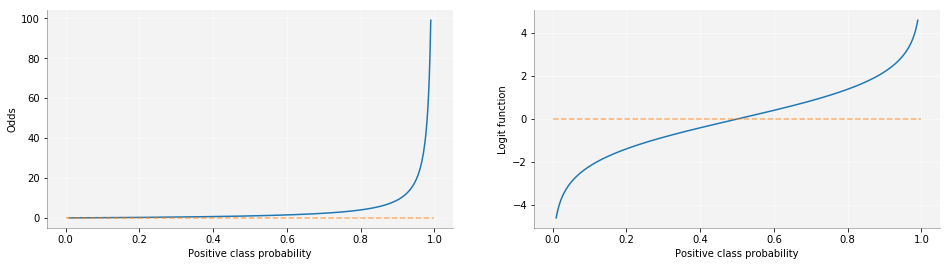

In [19]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(probs, odds)
plt.xlabel("Positive class probability")
plt.ylabel("Odds")
plt.plot([0, 1], [0, 0], "--", alpha=0.6)
set_plot_layout()

plt.subplot(1, 2, 2)
plt.plot(probs, logits)
plt.plot([0, 1], [0, 0], "--", alpha=0.6)
plt.xlabel("Positive class probability")
plt.ylabel("Logit function")
set_plot_layout()

We can see that the log odds, or $logit$ bounds our output between $[-\infty, +\infty]$, but the $logit$ can give us something very interesting that the $odds$ themselves cannot. If we find the **inverse** of $logit$, also known as the $sigmoid$, or $\sigma(z)$, then we'll find that the output of our odds, of our hypothesis, will be bounded between $[0, 1]$, which represents the probability of our sample belonging to a positive class!

With the output of the $sigmoid$ function, we can define a threshold for what we believe to be a positive case or a negative case. Let's go ahead and get the inverse of $logit$, then.

$$
\sigma(z) = logit^{-1}(p), \: where \: z \: is \: our \: prediction \: \theta\cdot X
$$

$$
z = ln \Big(\frac{p}{1 - p}\Big) \equiv
e^z = e ^ {ln \Big(\frac{p}{1 - p}\Big)} \equiv
e^z = \frac{p}{1 - p} \equiv
e^z(1 - p) = p \\\\
e^z - pe^y = p \equiv
e^z = p + pe^z \equiv
e^z = p(1 + e^z) \equiv
p = \boxed{\frac{e^z}{1 + e^z}}
$$

We can simplify it a bit more, by multiplying by $\cfrac{1}{e^z}$ on each side.

$$
\sigma(z) = \frac{e^z}{1 + e^z} = \frac{\frac{1}{e^z}e^z}{\frac{1}{e^z}(1 + e^z)} = \frac{1}{1 + e^{-z}}
$$

Adjusting our notation a bit, what we get is that $\hat{y} = h_{\theta}(x) = \sigma(\theta \cdot x) = \cfrac{1}{1 + e^{-\theta \cdot x}}$

Let's visualize this function as well:

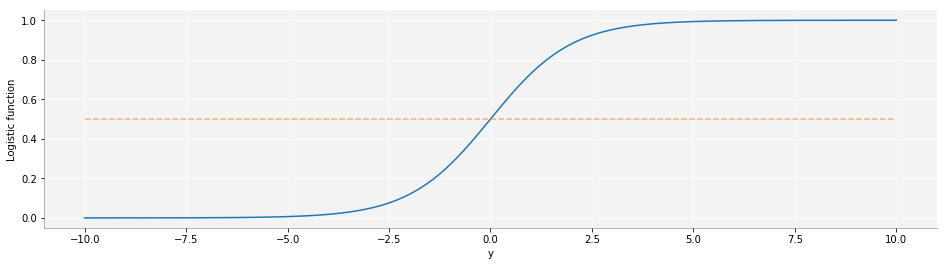

In [20]:
y = np.linspace(-10, 10, 300)
plt.figure(figsize=(16, 4))
logistic = 1 / (1 + np.exp(-y))
plt.plot(y, logistic)
plt.plot([-10, 10], [0.5, 0.5], "--", alpha=0.6)
plt.xlabel("y")
plt.ylabel("Logistic function")
set_plot_layout()

That's such a beautiful function, isn't it? It bounds our probabilities between $0$ and $1$, i.e $y \in [0, 1]$. In theory we can get either a $0$ or a $1$ as a result of the sigmoid function, but in practice that's quite uncommon.

As you can see we've created a transformation: now we have a non-linear function $\sigma(x)$ that represents the probabilities of the outputs of our models. We define a **threshold** which is standarized at $0.5$ (but can and *should* change according to the priorities of our models), which defines whether a sample belongs to a *Positive* ($\ge 0.5$) or to a *Negative* class ($\lt 0.5$).

In order for our Logistic Regression to learn the parameters $\theta$ of which the linear combination with $X$ gives us the odds, which are then run through our non-linear function $\sigma(\theta \cdot X)$, we need to define a *new* loss function, because as we saw, *MSE* was not made for classification.

This loss function is usually known as either **log loss** or **binary cross entropy**. In theory, they're different, but in practice they resolve to the same thing. This function is made specifically to punish wrong classifications, instead of the difference between continuos values, and it looks something like this:

$$
Let \: m \: be \: the \: total \: sample \: count \\
J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}log(h_{\theta}(x^{(i)})) + (1 - y^{(i)})log(1 - h_{\theta}(x^{(i)})
$$

Which can be vectorized to look like this:

$$
J(\theta) = -\frac{1}{m} (Y\cdot log(h_{\theta}(X)) + (1 - Y)\cdot log(1 - h_{\theta}(X)))
$$

where $h_{\theta}(X) = \sigma(\theta \cdot X)$ -- just for the sake of notation, we could simplify our lives and just say that $z = \theta \cdot X$, and as such $h_{\theta}(X) = \sigma(z)$ (which makes it more relatable to [Andrew Ng's video on it](https://www.youtube.com/watch?v=t1IT5hZfS48)). Something that is mentioned in Andrew's series is that, because we're applying a non-linear transformation, the cost functions used in linear regression **stop being convex**, which is actually a huge deal in these shallow models. We're running a naive optimizer that tries to find a minima, and it doesn't care if it's a local or global minima, for this very reason we want functions that have **only one minimum**, a.k.a: a *convex* function!

### Deriving our loss function $J(\theta)$

This one might be a bit longer than the one before. Let's use some better notation to define our variables and what we're using.

* We have our hypothesis $h_{\theta}(x)$.
* Our hypothesis $h_{\theta}(x) = \sigma(z)$, where $z = \theta \cdot x$.
* $\sigma(z)$ is the **sigmoid** or **logistic function** of the value $z$, which in turn is equal to the linear combination of our weights, or paremeters $\theta$ and our explanatory variable(s) $x$ (or $X$ if it was a vector of all of them).

Let's start by shaping $\sigma(z)$ in a way that makes it easier to differentiate, we'll have to use it later:

$$
\sigma(z) = \cfrac{1}{1 + e^{-z}} = (1 + e^{-z})^{-1}
$$

And now let's start differentiating:

$$
\cfrac{d\sigma(z)}{dz} = -(1 + e^{-z})^{-2}(-e^{-z}) = - \cfrac{-e^{-z}}{(1 + e^{-z})^{2}} = \cfrac{e^{-z}}{(1 + e^{-z})^{2}} \\
\cfrac{d\sigma(x)}{dz} = \cfrac{e^{-z}}{(1 + e^{-z})} \cdot \cfrac{1}{(1 + e^{-z})} = \cfrac{1 + e^{-z} - 1}{(1 + e^{-z})} \cdot \cfrac{1}{(1 + e^{-z})} \\
$$

By adding and substracting $1$ to $\cfrac{e^{-z}}{(1 + e^{-z})}$, we can pull a neat trick to get a very simple and beautiful derivative:

$$
\cfrac{d\sigma(z)}{dz} = \Big(\cfrac{(1 + e^{-z})}{(1 + e^{-z})} - \cfrac{1}{(1 + e^{-z})}\Big) \cdot \cfrac{1}{(1 + e^{-z})}
$$

And guess what, $\cfrac{1}{(1 + e^{-z})} = \sigma(z)$! As such, we get that:

$$
\boxed{\cfrac{d\sigma(z)}{dz} = (1 - \sigma(z))\cdot \sigma(z)}
$$

Let's move on to $J(\theta)$ itself:

$$
J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}log(h_{\theta}(x^{(i)})) + (1 - y^{(i)})log(1 - h_{\theta}(x(i))
$$

We need to apply the *chain rule* and we'll get something along the lines of this:

$$
\cfrac{dJ(\theta)}{d\theta} = \cfrac{dJ(\theta)}{dh_{\theta}} \cdot \cfrac{dh_{\theta}}{dz} \cdot \cfrac{dz}{d\theta}
$$

Let's go ahead and differentiate this bad boy. It's very important to note that $h_{\theta}(x^{(i)}) = \sigma(z) = \sigma(\theta \cdot x^{(i)})$

$$
\begin{align*}
\cfrac{J(\theta)}{d\theta} 
& = -\cfrac{1}{m}\sum_{i=1}^{m}y^{(i)}\cfrac{1}{\sigma(\theta \cdot x^{(i)})}\sigma(\theta \cdot x^{(i)})(1 - \sigma(\theta \cdot x^{(i)}))\cdot x^{(i)}
+ (1 - y^{(i)}) \cfrac{1}{1 - \sigma(\theta \cdot x^{(i)})}(-1)\sigma(\theta \cdot x^{(i)})(1 - \sigma(\theta \cdot x^{(i)})) \cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = -\cfrac{1}{m}\sum_{i=1}^{m}y^{(i)}(1 - \sigma(\theta \cdot x^{(i)}))\cdot x^{(i)} - (1 - y^{(i)})\sigma(\theta \cdot x^{(i)}))\cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = -\cfrac{1}{m}\sum_{i=1}^{m} y^{(i)}x^{(i)} - y^{(i)}\sigma(\theta \cdot x^{(i)})x^{(i)} - (\sigma(\theta \cdot x^{(i)})\cdot x^{(i)} - y^{(i)}\sigma(\theta \cdot x^{(i)})\cdot x^{(i)})\\
\cfrac{J(\theta)}{d\theta} & = -\cfrac{1}{m}\sum_{i=1}^{m} y^{(i)}x^{(i)} - y^{(i)}\sigma(\theta \cdot x^{(i)})x^{(i)} - \sigma(\theta \cdot x^{(i)})\cdot x^{(i)} + y^{(i)}\sigma(\theta \cdot x^{(i)})\cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = -\cfrac{1}{m}\sum_{i=1}^{m} y^{(i)}x^{(i)} - \sigma(\theta \cdot x^{(i)})\cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = -\cfrac{1}{m}\sum_{i=1}^{m} (y^{(i)} - \sigma(\theta \cdot x^{(i)})) \cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = -\cfrac{1}{m}\sum_{i=1}^{m} (y^{(i)} - \sigma(z)) \cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = -\cfrac{1}{m}\sum_{i=1}^{m} (y^{(i)} - h_{\theta}(x^{(i)}) \cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = \cfrac{1}{m}\sum_{i=1}^{m} -(y^{(i)} - h_{\theta}(x^{(i)}) \cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = \cfrac{1}{m}\sum_{i=1}^{m} (-y^{(i)} + h_{\theta}(x^{(i)}) \cdot x^{(i)} \\
\cfrac{J(\theta)}{d\theta} & = \cfrac{1}{m}\sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)}) \cdot x^{(i)}
\end{align*}
$$

What we've actually written here is not really just a derivative, but a **gradient**. It becomes more evident in vectorized form, where the result is a vector containing the partial derivative for *each parameter*.

Let's take this gradient into vectorized form:

$$
\cfrac{J(\theta)}{d\theta} = \cfrac{1}{m} (h_{\theta}(X) - Y) \cdot X
$$

Where $Y \in \mathbb{R}^m$ and $X \in \mathbb{R}^{m x n }$. Do note that we may need to transpose the matrices in the actual implementation to get a result. Finally, our gradient step ends up looking like this (assuming we have a new artificial, explanatory variable made of ones for the *bias* term):

$$
\theta = \theta - \alpha \cfrac{1}{m} (Y - h_{\theta}(X)) \cdot X, \: s.t \: \alpha \in \mathbb{R}
$$

### Logistic Regression implementation

In [21]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [22]:
class LogisticRegression:
    
    def __init__(self, alpha=1e-5, tol=1e-6, iterations=20):
        self.alpha = alpha
        self.tol = tol
        self.iters = iterations
        
    def predict_proba(self, X):
        if np.any(np.isnan(self.theta)):
            raise ValueError("fit function not yet called.")
        X = np.hstack([np.ones((len(X), 1)), X])
        return sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    
    def fit(self, X, y):
        assert len(X) == len(y)
        self.theta = np.zeros((X.shape[1] + 1, 1))
        history = []
        for i in range(1, self.iters + 1):
            prev_logloss = self.calculate_logloss(X, y)
            theta_change = self.calculate_gradients(X, y)
            history.append({
                "iteration": i,
                "theta": self.theta.copy(),
                "loss": prev_logloss
            })
            self.theta -= theta_change
            logloss = self.calculate_logloss(X, y)
            if abs(prev_logloss - logloss) < self.tol:
                print("Converged at iteration {}.".format(i))
                break
        return history
        
    def calculate_gradients(self, X, y):
        m = len(X)
        preds = self.predict_proba(X)
        X = np.hstack([np.ones((len(X), 1)), X])
        theta_change = self.alpha * (1/m) * np.dot(X.T, (preds - y))
        return theta_change
    
    def calculate_logloss(self, X, y):
        preds = self.predict_proba(X)
        m = len(X)
        # Transposing to be able to vectorize and use matrix multiplication
        return np.asscalar(- 1 / m * (np.dot(y.T, np.log(preds)) + np.dot((1 - y).T, np.log(1 - preds))))
    

### Running and Measuring the performance of our Logistic Regression

In [23]:
X_0, y_0 = np.hstack([np.random.uniform(0, 5, size=(100, 1)), np.random.uniform(6, 10, size=(100, 1))]), np.zeros((100, 1))
X_1, y_1 = np.hstack([np.random.uniform(6, 10, size=(100, 1)), np.random.uniform(0, 5, size=(100, 1))]), np.ones((100, 1))

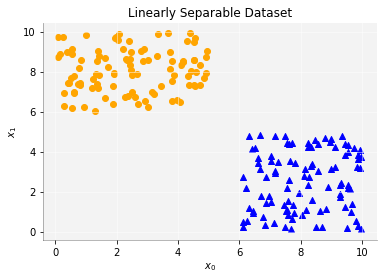

In [24]:
plt.scatter(X_0[:, 0], X_0[:, 1], c="orange", marker="o")
plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", marker="^")
plt.title("Linearly Separable Dataset")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
set_plot_layout()

In [25]:
X_0.shape

(100, 2)

In [26]:
# Let's get our dataset into a more proper shape.
X = np.vstack([X_0, X_1])
y = np.vstack([y_0, y_1])

#### Running our Logistic Regression

Converged at iteration 11.


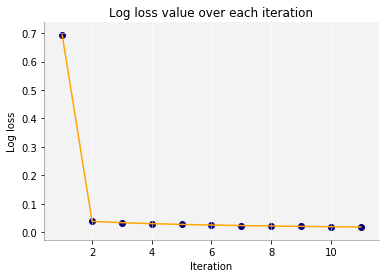

In [27]:
# Instantiate our classifier and fit it
classifier = LogisticRegression(alpha=0.5, iterations=100, tol=1e-3)
history = classifier.fit(X, y)

# Visualize the loss over iterations
iteration, loss = zip(*[(hist["iteration"], hist["loss"]) for hist in history])
plt.plot(iteration, loss, c="orange")
plt.scatter(iteration, loss, c="navy")
plt.title("Log loss value over each iteration")
plt.xlabel("Iteration")
plt.ylabel("Log loss")
set_plot_layout()

#### Evaluating it

Usually, in classifiers, we don't really get to see the decision boundary it created directly, but rather we measure its performance through **metrics**. I won't go into detail here as each metric is more useful or more important depending on what we're doing, so here we're going to use an extremely naive metric known as **accuracy** (which you're not actually supposed to use for many reasons, the ones I've seen the most are Precision and Recall), which answers the question: **What is the ratio of predictions that effectively match its true target value?**

And it's calculated as you may imagine:

- Let $P$ be a vector of predictions where $P \in \mathbb{R}^{m}$, such that $m$ is the *sample size*, and the values of $P$ are in the discrete interval $\{0, 1\}$.
- Let $Y$ be a vector of true target values, such that $Y \in \mathbb{R}^{m}$, such that $m$ is the *sample size*, and the values of $Y$ are in the discrete interval $\{0, 1\}$.
- Let $M$ be a vector of matches, such that $P \in \{0, 1\}^m$ and  $M_i = 1 \iff P_i = Y_i$ and $M_i = 0$ otherwise, where $m$ is the *sample size*.
- What I mean when I don't try too hard to look like a mathematician (I'm not) is that $P$ and $Y$ must have the same dimensions and have either $0$ or $1$ as their value, and we define a vector of matches comprised of 0s and 1s, where the 1s represent an index of both vectors $P$ and $Y$ where they are equal.
- We define accuracy as:

$$
accuracy = \cfrac{\sum_{i=0}^{m} M_i}{m}
$$

And we can code it like this:

In [28]:
p = classifier.predict(X)
m = len(X)
acc = np.sum(p == y) / m
print("The accuracy of the model against the training set is: {}%".format(int(np.asscalar(acc) * 100)))

The accuracy of the model against the training set is: 100%


#### Decision boundary

We can actually see the decision boundary, and in order to do this we most solve for $\theta\cdot X = 0$, let's see why. Remember our Sigmoid (or Logistic) Function? -- let's refresh it

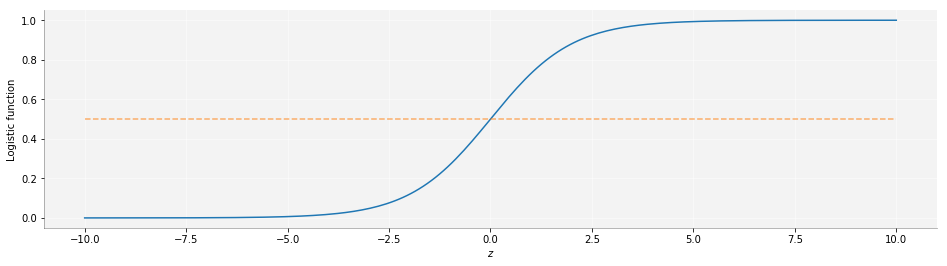

In [29]:
x = np.linspace(-10, 10, 200)
plt.figure(figsize=(16, 4))
logistic = 1 / (1 + np.exp(-x))
plt.plot(x, logistic)
plt.plot([-10, 10], [0.5, 0.5], "--", alpha=0.6)
plt.xlabel("$z$")
plt.ylabel("Logistic function")
set_plot_layout()

Where $z = \theta \cdot X$ -- this means that whenever $z \ge 0$, we'll get values greater than $0.5$, and when it's less than 0, we'll get something less than 0.5. This is, in fact, our default decision boundary because we're using $0.5$ to choose. So what we need to do is, in fact, solve $\theta \cdot X = 0$.

Let's unwrap this vector notation and see what it looks like.

$$
\theta \cdot X = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n
$$

Where $n$ is the amount of explanatory variables we have. We have to solve this equation by equaling it to 0 since we're using a **treshold of $0.5$**, this means that $\hat{y} = 1 \iff h_{\theta} \ge 0.5$. Since we're using $2$ explanatory variables, (actually $3$ because of our bias term), unwrapping $\theta \cdot X$ would look like this:

$$
\theta \cdot X = \theta_0 + \theta_1 x_1 + \theta_2 x_2
$$

and solving for $x_2$ and having $\hat{y} = 1 \iff h_{\theta} \ge 0.5$:

$$
\begin{align*}
\theta_0 + \theta_1 x_1 + \theta_2 x_2 &= 0 \\
\theta_0 + \theta_1 x_1 &= -\theta_2 x_2 \\
- \cfrac{\theta_0 + \theta_1 x_1}{\theta_2} &= x_2
\end{align*}
$$

And now we can assemble our decision boundary:

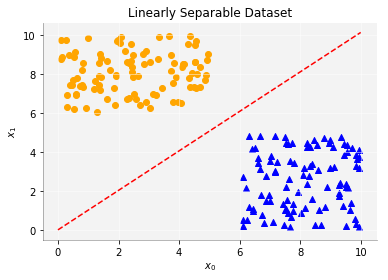

In [30]:
theta_0, theta_1, theta_2 = classifier.theta
x_1 = np.linspace(0, 10, len(X))
x_2 = -(theta_0 + theta_1 * x_1) / theta_2
plt.plot(x_1, x_2, "--", c="red")
plt.scatter(X_0[:, 0], X_0[:, 1], c="orange", marker="o")
plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", marker="^")
plt.title("Linearly Separable Dataset")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
set_plot_layout()

Voila! That's the reason we have $100%$ accuracy, because the decision boundary separates both classes perfectly!

This is easy to visualize because we're in $\mathbb{R}^2$, and it'd also be possible in $\mathbb{R}^3$, but as the amount of explanatory variables we have available grows, the decision boundary eventually becomes impossible to visualize, and for this reason (among others!) we come to rely on metrics, of course that this also applies to Regressors.

#### Working with non-linearity

Suppose now that our data is not linearly separable, meaning that it looks something like this:

In [31]:
theta = np.linspace(0, 2*np.pi, 100)
X_0, y_0 = np.vstack([4 * np.cos(theta), 4 * np.sin(theta)]).T, np.zeros((100, 1))
X_1, y_1 = np.vstack([6 * np.cos(theta), 6 * np.sin(theta)]).T, np.ones((100, 1))

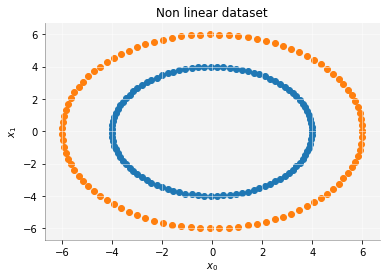

In [32]:
plt.scatter(X_0[:, 0], X_0[:, 1])
plt.scatter(X_1[:, 0], X_1[:, 1])
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.title("Non linear dataset")
set_plot_layout()

In [33]:
X = np.vstack([X_0, X_1])
y = np.vstack([y_0, y_1])

What happens if we train our Logistic Regression on it?

In [34]:
classifier = LogisticRegression(alpha=0.1, iterations=10000, tol=1e-6)
history = classifier.fit(X, y)

Converged at iteration 2.


In [35]:
pd.DataFrame(history[-10:][::-1])

,iteration,loss,theta
0,2,0.693145,"[[0.0], [0.0004999999999999983], [3.4972025275..."
1,1,0.693147,"[[0.0], [0.0], [0.0]]"


Our loss really does suck, what if we create **polynomial features**? -- this has a name, it's called **feature engineering**.

In [36]:
poly_X = np.array([X[:, 0], X[:, 1], X[:, 0] ** 2, X[:, 1] ** 2]).T

In [37]:
classifier = LogisticRegression(alpha=0.1, iterations=10000, tol=1e-6)
history = classifier.fit(poly_X, y)

Converged at iteration 7885.


In [38]:
pd.DataFrame(history[-10:][::-1])

,iteration,loss,theta
0,7885,0.008273,"[[-12.256726764472958], [-0.000827090303139179..."
1,7884,0.008274,"[[-12.256410982418958], [-0.000827091140813981..."
2,7883,0.008275,"[[-12.256095162367524], [-0.000827091978691109..."
3,7882,0.008276,"[[-12.255779304309556], [-0.000827092816770643..."
4,7881,0.008277,"[[-12.255463408235949], [-0.000827093655052649..."
5,7880,0.008278,"[[-12.255147474137594], [-0.000827094493537200..."
6,7879,0.008279,"[[-12.254831502005379], [-0.000827095332224372..."
7,7878,0.008280,"[[-12.254515491830189], [-0.000827096171114240..."
8,7877,0.008281,"[[-12.254199443602905], [-0.000827097010206875..."
9,7876,0.008282,"[[-12.253883357314407], [-0.000827097849502347..."


We don't really have to scale our values because they're considerable smaller than the ones we used for Linear Regression, so the steps in each dimension in the surface that the gradient descent is optimizing are quite similar. We've also seem to have reached a very low loss! Let's check out our accuracy.

In [39]:
p = classifier.predict(poly_X)
m = len(X)
acc = np.sum(p == y) / m
print("The accuracy of the model against the training set is: {}%".format(int(np.asscalar(acc) * 100)))

The accuracy of the model against the training set is: 100%


Huh! It seems to have reached perfect accuracy. There's something interesting to see about this fit, check out the last values of $\theta$.

In [40]:
classifier.theta

array([[-1.22570425e+01],
       [-8.27089466e-04],
       [-1.48173140e-16],
       [ 4.87096650e-01],
       [ 4.87088247e-01]])

The values in $\theta_1$ and $\theta_2$ are the values for the explanatory variables $x_1$ and $x_2$ respectively. They're extremely close to zero, actually, it's likely that if we didn't have floating point precision, $\theta_2$ would be 0! This means that our model is actually barely (if not at all) even using $\theta_1, \theta_2$, and we can draw our decision boundary based on $\theta_0, \theta_3, \theta_4$.

In [41]:
theta_0, theta_3, theta_4 = classifier.theta[[0, 3, 4]]

In [42]:
theta_0, theta_3, theta_4

(array([-12.25704251]), array([0.48709665]), array([0.48708825]))

Which we may express as a function that represents an ellipse:

$$
\begin{align*}
\theta_3x_1^2 + \theta_4x_2^2 &= \theta_0 \\
\cfrac{\theta_3x_1^2 + \theta_4x_2^2}{\theta_0} &= \cfrac{\theta_0}{\theta_0}\\
\cfrac{\theta_3x_1^2}{\theta_0} + \cfrac{\theta_4x_2^2}{\theta_0} &= 1
\end{align*}
$$

In [43]:
# Get the width and height by zeroing out one explanatory variable and solve for the non-zero explanatory variable.
width = 1 / (theta_3 / -theta_0)
height = 1 / (theta_4 / -theta_0)

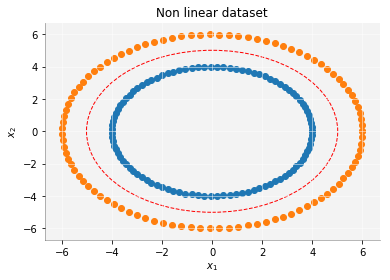

In [44]:
from matplotlib.patches import Ellipse
plt.figure()
boundary = Ellipse((0, 0), width=np.sqrt(width) * 2, # Times two in order to cover the full width.
                           height=np.sqrt(height) * 2 , # Same here for the full height
                           color="r", 
                           fill=False, 
                           linestyle="--")
ax = plt.gca()
ax.add_artist(boundary)
plt.scatter(X_0[:, 0], X_0[:, 1])
plt.scatter(X_1[:, 0], X_1[:, 1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Non linear dataset")
set_plot_layout()

As we can see, by engineering our features $x_1$ and $x_2$ and projecting them into a non-linear space, our model has effectively prioritized their squared versions and effectively learned a non-linear decision obundary for our data. It's been a wild ride for me writing this, and may contain some errata as well, and you're welcome to let me know about it through either GitHub or wherever you see this posted, especially on the mathematical notation. I did my best to write it properly, but it may have some essential mistakes.

This has been very useful for me to properly understand how things work under the hood instead of the shallow knowledge that I used to have. I hope it's also useful for somebody else as well!

**Good luck!**

Juan Amari

# Sources
- [Andrew Ng's Machine Learning course](https://www.coursera.org/learn/machine-learning).
- [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) and [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) on Wikipedia.
- [Derivation of Log Loss](http://www.haija.org/derivation_logistic_regression.pdf).
- [Roey Ron](https://www.linkedin.com/in/roey-ron-7644a8162/) for helping me understanding my lacking of knowledge in Geometrics to draw that Ellipse.